In [1]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import rich.table
import planetary_computer
from pystac_client import Client

from IPython.display import Image

## 6/27 END OF DAY
- took a bit to figure out where to find my planetary computer account api key
    here: https://github.com/microsoft/PlanetaryComputer/discussions/77 
    - added my API key as an environment variable and restarted the conda env but now the kernel dies whenever I try to run a command? not sure what's up... 

Following instructions from the [S1 RTC Example notebook](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook)

In [3]:
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
catalog

<Client id=microsoft-pc>

Specify time range and bounding box of interest: 

In [4]:
time_range = '2015-01-01/2022-05-01'
bbox = [88.214935, 27.932767, 88.263184,  28.017289]

Search for items in the collection you're interested in (here, S1 RTC) matching those parameters. 
Looks like there are 100 scenes in the dataset that match the criteria I specified:

In [5]:
search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

100

Convert to geodataframe and explore:

In [6]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
df.head(1)

,geometry,datetime,platform,s1:shape,proj:bbox,proj:epsg,proj:shape,end_datetime,constellation,s1:resolution,...,sar:center_frequency,sar:resolution_range,s1:product_timeliness,sar:resolution_azimuth,sar:pixel_spacing_range,sar:observation_direction,sar:pixel_spacing_azimuth,sar:looks_equivalent_number,s1:instrument_configuration_ID,sat:platform_international_designator
0,"POLYGON ((89.80391 27.02294, 89.82898 27.27428...",2022-04-30T00:03:27.201903Z,SENTINEL-1A,"[27531, 21084]","[530180.0, 2980920.0, 798685.0, 3190410.0]",32645,"[27531, 21084]",2022-04-30 00:03:39.701264+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,7,2014-016A


In [7]:
df.explore()

In [8]:
item0 = items[0]

Taking a look at a false color composite from a combination of VV, VH bands from the first item in the `items` list: 

In [46]:
Image(url=item0.assets['rendered_preview'].href)

## Inspect STAC metadata


In [9]:
table = rich.table.Table('key','value')
for k, v in sorted(item0.properties.items()):
    table.add_row(k, str(v))
    
table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                                        │
│ datetime                              │ 2022-04-30T00:03:27.201903Z                       │
│ end_datetime                          │ 2022-04-30 00:03:39.701264+00:00                  │
│ platform                              │ SENTINEL-1A                                       │
│ proj:bbox                             │ [530180.0, 2980920.0, 798685.0, 3190410.0]        │
│ proj:epsg                             │ 32645                                             │
│ proj:shape                            │ [27531, 21084]                                    │
│ proj:transform                        │ [10.0, 0.0, 524470.0, 0.0, -10.0, 3191680.0, 0.0, │
│                                       │ 0.0, 1.0]                                         │
│ s1:datatake_id                        │ 336414                                            │
│ s1:instrument_configuration_ID        │ 7                                                 │
│ s1:orbit_source                       │ RESORB                                            │
│ s1:processing_level                   │ 1                                                 │
│ s1:product_timeliness                 │ Fast-24h                                          │
│ s1:resolution                         │ high                                              │
│ s1:shape                              │ [27531, 21084]                                    │
│ s1:slice_number                       │ 12                                                │
│ s1:total_slices                       │ 17                                                │
│ sar:center_frequency                  │ 5.405                                             │
│ sar:frequency_band                    │ C                                                 │
│ sar:instrument_mode                   │ IW                                                │
│ sar:looks_azimuth                     │ 1                                                 │
│ sar:looks_equivalent_number           │ 4.4                                               │
│ sar:looks_range                       │ 5                                                 │
│ sar:observation_direction             │ right                                             │
│ sar:pixel_spacing_azimuth             │ 10                                                │
│ sar:pixel_spacing_range               │ 10                                                │
│ sar:polarizations                     │ ['VV', 'VH']                                      │
│ sar:product_type                      │ GRD                                               │
│ sar:resolution_azimuth                │ 22                                                │
│ sar:resolution_range                  │ 20                                                │
│ sat:absolute_orbit                    │ 42995                                             │
│ sat:orbit_state                       │ descending                                        │
│ sat:platform_international_designator │ 2014-016A                                         │
│ sat:relative_orbit                    │ 48                                                │
│ start_datetime                        │ 2022-04-30 00:03:14.702542+00:00                  │
└───────────────────────────────────────┴───────────────────────────────────────────────────┘

In [10]:
item0.properties["sar:polarizations"]

['VV', 'VH']

## Visualize assets

load `vv` data into xarray and plot results. we'll use dask here, see scaling with dask link in example notebook

In [11]:
from distributed import Client

client = Client(processes=False)
print(client.dashboard_link)

http://128.117.11.172:8787/status


## stackstac

STAC = Spatio-Temporal Asset Catalog
STAC provides a common framework for describing and cataloging spatiotemporal assets 

STAC objects: 

**STAC Item**
unit representing single spatiotemporal asset as a GeoJSON feature plus datetime and links

**STAC Catalog**
JSON file of links that provides structure to organize, browse **STAC items**

**STAC Collection**
extension of STAC catalog w/ additional info including extents, licenses, keywords metadata etc.

**STAC API**
RESTful endpoint that enables search of STAC items

To load the identified data as xarray objects, we'll use `stackstac` which is a package that facilitates cloud-native raster geoprocessing.

stackstac.stack turns a `stack` collection into a lazy xarray.DataArray backed by dask (from docs)
- transfers STAC metadata to xarray coordinates


In [10]:
type(items)

pystac.item_collection.ItemCollection

Let's take a look at the below command where we build the object `ds`. 

We are calling stackstac.stack() which helps us build an xarray object from the spatiotemporal asset catalog. 

`stackstac.stack()` takes a STAC collection (check this) of STAC items and creates a DataArray of the STAC items reprojected to the same grid and stacked by time. The `items` object can also be a list of python dicts.

Within `stackstac.stack()`, we are calling `planetary_computer.sign()` on the items we identified earlier. This is using the API key associated with your planetary computer account. The other parameters included in `stackstac.stac()` are bounds_latlon, epsg and resolution. 

Providing the `epsg` parameter will return a DataArray reprojected to the epsg code you provide. 

The `resolution` parameter specifies the spatial resolution of the output data array, so the data will be resampled to the provided resolution. Be careful to provide this in the same units as the CRS.

`bounds_latlon` provides the spatial bounding box of the output object in degrees. If we didn't specify a bounds when we create this object, the output would be 15 GB. Clipping it to the bounds we defined above means that it's only 7 mb! 

You can check out all of the parameters that can be included when calling `stackstac.stack()` [here](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html)

In [11]:
import stackstac
#bounds_latlon=bbox,
ds = stackstac.stack(
    planetary_computer.sign(items), bounds_latlon=bbox, epsg=32645, resolution = 100
)
ds

,Array,Chunk
Bytes,7.10 MiB,36.37 kiB
Shape,"(100, 2, 95, 49)","(1, 1, 95, 49)"
Count,600 Tasks,200 Chunks
Type,float64,numpy.ndarray


In [27]:
ds.sel(band = 'vv')

<xarray.DataArray 'stackstac-bfab9a8eb41a69b2ab501fc323b78228' (time: 100, y: 95, x: 49)>
dask.array<getitem, shape=(100, 95, 49), dtype=float64, chunksize=(1, 95, 49), chunktype=numpy.ndarray>
Coordinates:
  * time                                   (time) datetime64[ns] 2020-08-23T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2020...
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.242e+05
  * y                                      (y) float64 3.1e+06 ... 3.09e+06
    sat:platform_international_designator  <U9 '2014-016A'
    s1:resolution                          <U4 'high'
    sar:frequency_band                     <U1 'C'
    sar:center_frequency                   float64 5.405
    platform                               <U11 'SENTINEL-1A'
    sar:pixel_spacing_range                int64 10
    s1:instrument_configuration_ID         (time) <U1 '6' '6' '6' ... '7' '7'
    s1:product_timeliness                  <U8 'Fast-24h'
    sar:observation_direction              <U5 'right'
    s1:datatake_id                         (time) <U6 '258895' ... '336414'
    sar:product_type                       <U3 'GRD'
    sat:absolute_orbit                     (time) int64 34034 34070 ... 42995
    sar:resolution_azimuth                 int64 22
    s1:orbit_source                        (time) <U8 'RESORB' ... 'RESORB'
    sar:looks_azimuth                      int64 1
    sar:looks_equivalent_number            float64 4.4
    s1:processing_level                    <U1 '1'
    end_datetime                           (time) <U32 '2020-08-23 12:14:16.2...
    start_datetime                         (time) <U32 '2020-08-23 12:13:51.2...
    sar:instrument_mode                    <U2 'IW'
    sar:polarizations                      object {'VH', 'VV'}
    sar:looks_range                        int64 5
    constellation                          <U10 'Sentinel-1'
    sat:orbit_state                        (time) <U10 'ascending' ... 'desce...
    s1:slice_number                        (time) <U2 '6' '12' '12' ... '6' '12'
    sar:pixel_spacing_azimuth              int64 10
    sat:relative_orbit                     (time) int64 12 48 48 12 ... 48 12 48
    proj:epsg                              int64 32645
    s1:total_slices                        (time) <U2 '20' '17' ... '20' '17'
    sar:resolution_range                   int64 20
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  <U41 'VV: vertical transmit, verti...
    description                            <U173 'Terrain-corrected gamma nau...
    epsg                                   int64 32645
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(619400, 3090300, 624300, 3099...
    crs:         epsg:32645
    transform:   | 100.00, 0.00, 619400.00|\n| 0.00,-100.00, 3099800.00|\n| 0...
    resolution:  100

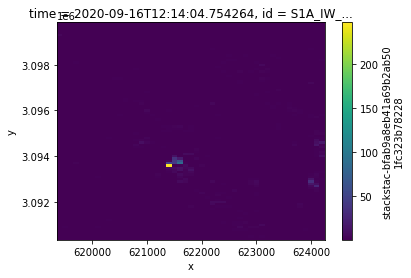

In [28]:
ds.sel(band = 'vv').isel(time=3).plot()

units are intensity ?

data description [here](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc)

## Cleaning
- polarizations come as coords but we probably want them as vars


In [38]:
ds

,Array,Chunk
Bytes,7.10 MiB,36.37 kiB
Shape,"(100, 2, 95, 49)","(1, 1, 95, 49)"
Count,600 Tasks,200 Chunks
Type,float64,numpy.ndarray


In [ ]:
ds['vv'] = ds.sel(

## Groupby seasons

In [46]:
gb_vv = ds.sel(band='vv').groupby(ds.time.dt.season).mean()
gb_vv

<xarray.DataArray 'stackstac-bfab9a8eb41a69b2ab501fc323b78228' (season: 4, y: 95, x: 49)>
dask.array<stack, shape=(4, 95, 49), dtype=float64, chunksize=(1, 95, 49), chunktype=numpy.ndarray>
Coordinates:
    band                                   <U2 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.242e+05
  * y                                      (y) float64 3.1e+06 ... 3.09e+06
    sat:platform_international_designator  <U9 '2014-016A'
    s1:resolution                          <U4 'high'
    sar:frequency_band                     <U1 'C'
    sar:center_frequency                   float64 5.405
    platform                               <U11 'SENTINEL-1A'
    sar:pixel_spacing_range                int64 10
    s1:product_timeliness                  <U8 'Fast-24h'
    sar:observation_direction              <U5 'right'
    sar:product_type                       <U3 'GRD'
    sar:resolution_azimuth                 int64 22
    sar:looks_azimuth                      int64 1
    sar:looks_equivalent_number            float64 4.4
    s1:processing_level                    <U1 '1'
    sar:instrument_mode                    <U2 'IW'
    sar:polarizations                      object {'VH', 'VV'}
    sar:looks_range                        int64 5
    constellation                          <U10 'Sentinel-1'
    sar:pixel_spacing_azimuth              int64 10
    proj:epsg                              int64 32645
    sar:resolution_range                   int64 20
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  <U41 'VV: vertical transmit, verti...
    description                            <U173 'Terrain-corrected gamma nau...
    epsg                                   int64 32645
  * season                                 (season) object 'DJF' 'JJA' ... 'SON'

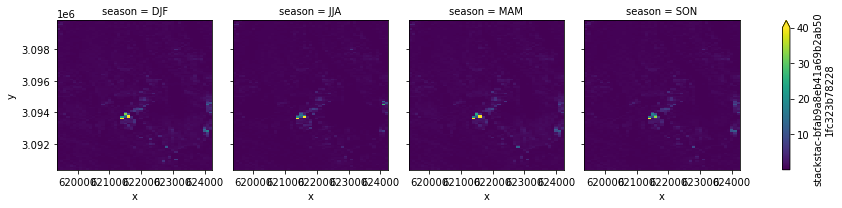

In [48]:
fg_season_vv = gb_vv.plot(col='season', vmax=40)

In [49]:
gb_vh = ds.sel(band='vh').groupby(ds.time.dt.season).mean()


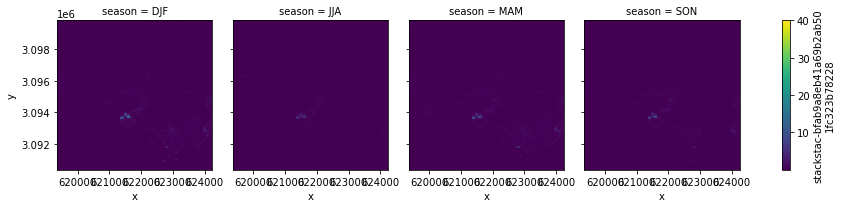

In [50]:
fg_season_vh = gb_vh.plot(col='season', vmax=40)

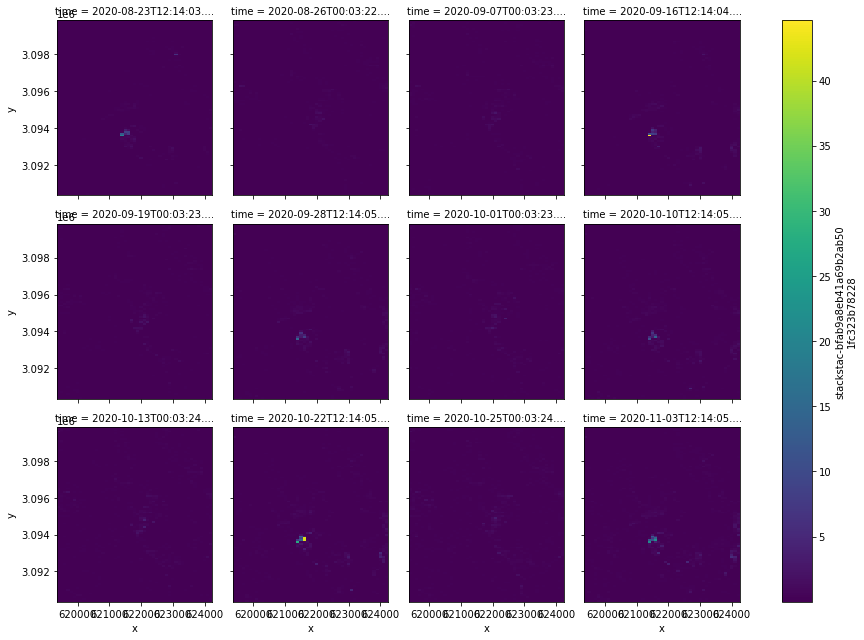

In [35]:
fg = ds.sel(band = 'vh').isel(time=slice(0,12)).plot(
    col='time', col_wrap =4)